# ` Spatial Analytics Code Challenge `

In [114]:
import pandas as pd
import numpy as np
import json
import os, sys
import matplotlib.pyplot as plt
import datetime 
from collections import Counter, defaultdict
import pickle
import warnings
warnings.filterwarnings("ignore")

# ML algorithms
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

%matplotlib inline
%autosave 180
plt.style.use('seaborn-whitegrid')

# Setting up global vairables for folder paths to read and save files
# Make sure to modify the path! Otherwise, this notebook may not reproduce the same result 

folder_path = "/Users/soohyunlee/Desktop/python/Spatial-Analytics/chlor_a"
pickle_folder_path = "/Users/soohyunlee/Desktop/python/Spatial-Analytics/solution/pickles"
results_folder_path = "/Users/soohyunlee/Desktop/python/Spatial-Analytics/solution/results"

Autosaving every 180 seconds


## <font color=#003666> • Initial Setup & EDA </font>

<font color= red> **Key facts about the data and data preprocessing decisions: </font>**
 
1. Total there are 203 files whose naming format is "chlor_yyyyddd." 
    - Use this information to create columns for year, month, day, doy 
2. Each dataset contains 720 rows and 1201 columns.
3. Provided latitudes/longitudes are eqaul across all 203 files (used set subtraction operation to find diff).
4. When loaded as pandas dataframe, the "longitude" column was parsed as "string" object. Therefore, the column was converted into "float" type during data preprocessing.
5. The provided dataset had a larger coverage than what is stated in the problem set. 
    - Original Dataset: (10-70°N) & ((-0) -(-99)°E)
    - Problem Statement: (10-70°N) & ((-0) - (-50)°E) 
    - Hence, the data was filtered/truncated to adjust to the correct range.

In [2]:
# Data Evaluation Example
corr_file_num = 0
for file in os.listdir(folder_path):
    data = pd.read_csv("/".join([folder_path, file]))
    
    if data.shape != (720,1201): # Checking if the data has different number of entries 
        print (file)
    else:
        corr_file_num += 1 
print ("Checked {} files and {} have the same shape".format(len(os.listdir(folder_path)), corr_file_num))

Checked 203 files and 203 have the same shape


## <font color=#003666> • Functions to parse the input data & saving as pickle/csv </font>

In [2]:
# Running for the first time

def run_init():
    """
    Reading all 203 files and parsing the raw data as a defaultdict(list of df)
    """
    
    data_collection = defaultdict(list)
    for file_name in os.listdir(folder_path):
        if file_name.endswith("csv"):
            year, doy = int(file_name[8:12]), int(file_name[12:15])
            record_date = (datetime.datetime(year, 1, 1) + datetime.timedelta(doy-1))
            df = pd.read_csv(("/").join([folder_path, file_name]), index_col = 0)
            df = df.unstack().reset_index()
            df.rename(columns={"level_0":"longitude", "level_1": "latitude", 0:"chlor_a_val"}, inplace=True)

            # Adding date attributes
            df["year"] = record_date.year
            df["month"] = record_date.month
            df["day"] = record_date.day
            df["doy"] = doy

            data_collection[record_date.year] += [df]
    return data_collection

In [3]:
# Concatanating the dataframes
def create_data_dict_raw(data_collection, 
                         lat_min=None, lat_max=None, long_min=None, long_max=None):
    data_dict_raw = {}
    for year, data in data_collection.items():
        df_temp = pd.concat(data_collection[year]).reset_index(drop=True)

        # "Longitude" is recorded as "string", so need to convert to "float"
        df_temp["longitude"] = df_temp["longitude"].astype(float) 

        # Adjusting the longitude for the correct range between -50° and -0° E following the instruction 
        # This will get rid of ~50% of the data, speeding up the computation
        if (lat_min and lat_max and long_min and long_max):
            df_temp = df_temp[(df_temp.longitude <= long_max) & 
                              (df_temp.longitude >= long_min) &
                              (df_temp.latitude < lat_max) & 
                              (df_temp.latitude >= lat_min) ]

        else:
            df_temp = df_temp[(df_temp.longitude < 0) & (df_temp.longitude >= -50) ]

        data_dict_raw[year] = df_temp
    return data_dict_raw

In [4]:
# For dictionary and defaultdict objects

# Saving to the pickle object
def save_to_pickle(data_object, file_name):
    with open(("/").join([pickle_folder_path, file_name+".pickle"]), "wb") as handle:
        pickle.dump(data_object, handle,
                    protocol=pickle.HIGHEST_PROTOCOL)
        
# Loading from the pickle object        
def read_from_pickle(file_name):
    with open(("/").join([pickle_folder_path, file_name+".pickle"]), "rb") as handle:
        data_object = pickle.load(handle)
    return data_object

### <font color=#0085ad> • Running for the first time </font>

In [ ]:
data_collection = run_init()
save_to_pickle(data_object = data_collection, 
               file_name = "data_collection")

data_dict_raw = create_data_dict_raw(data_collection=data_collection)
save_to_pickle(data_object = data_dict_raw, 
               file_name = "data_dict_raw")

### <font color=#0085ad> • Running for the second time ++ </font>

In [5]:
data_collection = read_from_pickle("data_collection")
data_dict_raw = read_from_pickle("data_dict_raw")

# <font color=#003666> Part I: Exploratory Data Analysis </font>
### <font color=#0085ad> Q1 : Plot the mean Chlorophyll-⍺ concentration in the North Atlantic Ocean </font>

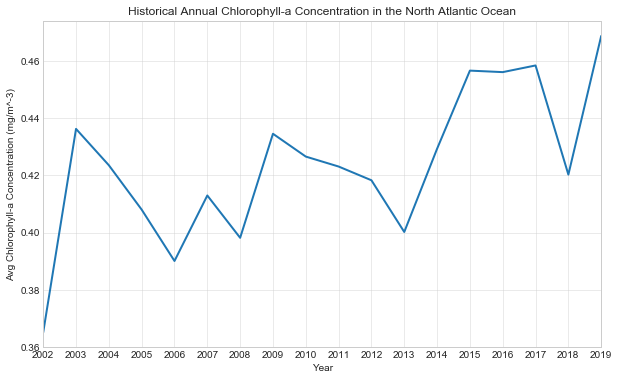

In [6]:
# Annual Average
def get_annual_chlor_avg(print_output=False):
    avg_chlor = []
    for year, df in data_dict_raw.items():
        annual_avg = df.chlor_a_val.mean()
        avg_chlor.append(annual_avg)
        if print_output:
            print ("Year: {}, Avg Chlorophyll-a concentration: {}".format(year, annual_avg))

    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(range(2002,2020), avg_chlor, lw=2)
    ax.grid(alpha=0.5)
    ax.set_title("Historical Annual Chlorophyll-a Concentration in the North Atlantic Ocean")
    ax.set_xlabel("Year")
    ax.set_ylabel("Avg Chlorophyll-a Concentration (mg/m^-3)")
    ax.set_xlim(2002,2019)
    ax.set_xticks(np.arange(2002, 2020, 1));

get_annual_chlor_avg(print_output=False)

<font color=red> **Comment:**</font> 
> The plot above illustrates an upward trend over time between 2002 and 2019. It would be worthwhile to investigate the effect of **detrending** for any further analysis as its significance maybe a good indicator for **climatic (long-term) changes**. Also, note that year 2002 and 2019 have different numbers of data points (2012: July-Dec, 2019: Jan-May). This may dragged the graph more downward and upward relatively. 

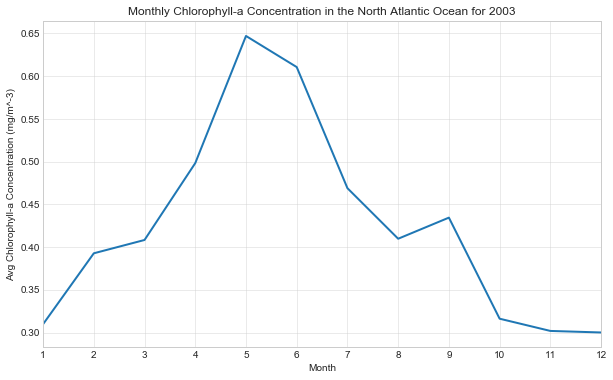

In [14]:
# Monthly Average within a particular year
def get_monthly_avg(data_dict_raw=data_dict_raw, year=2003, print_output=False): # example year is 2002 
    avg_chlor = []
    if print_output:
        print("- For Year: {}".format(year), "\n")
    for month, df in data_dict_raw[year].groupby("month"):
        monthly_avg = df.chlor_a_val.mean()
        avg_chlor.append(monthly_avg)
        if print_output:
            print ("Month: {}, Avg Chlorophyll-a concentration: {}".format(month, monthly_avg))
    
    fig, ax = plt.subplots(1,1, figsize=(10,6))
    ax.plot(range(1,13), avg_chlor, lw=2)
    ax.grid(alpha=0.5)
    ax.set_title("Monthly Chlorophyll-a Concentration in the North Atlantic Ocean for {}".format(year))
    ax.set_xlabel("Month")
    ax.set_ylabel("Avg Chlorophyll-a Concentration (mg/m^-3)")
    ax.set_xlim(1,12)
    ax.set_xticks(np.arange(1, 13, 1));
        
# Example        
get_monthly_avg(year=2003, print_output=False)

<font color=red> **Comment:**</font> 
> It appears that the chlorophyll-⍺ is **highest** in early summer **(May-June)** and the **lowest** in the winter **(Nov-Jan)**. Such a short-term variation could be caused by the changes in **cloud cover**, which can reduce or increase solar energy available for photosynthesis.

### <font color=#0085ad> Q2 : Other than the land, which parts of the North Atlantic Ocean are missing the most data? Is there a geographic or temporal bias (seasonal or otherwise) in the percentage of data that is missing? </font>

####  <font color=#0085ad> Q2 - 1. Temporal Bias </font>

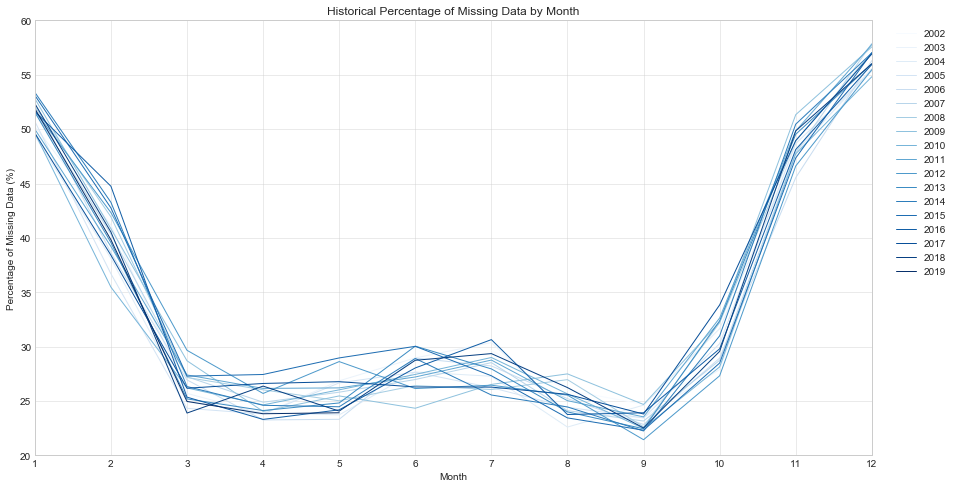

In [15]:
fig, ax = plt.subplots(1,1, figsize=(15,8))
cmap=plt.get_cmap("Blues")
colors = cmap(np.linspace(0, 1, num=18))
num = 0

for year, df in data_dict_raw.items():
    x_months, y_values = [], []
    for month, df_2 in data_dict_raw[year].groupby("month"):
        x_months.append(month)
        percentage_missing = df_2.chlor_a_val.isnull().sum()/len(df_2.chlor_a_val)*100
        y_values.append(percentage_missing)

    ax.plot(x_months, y_values, label=year, lw=1, c=colors[num])
    num += 1

ax.grid(alpha=0.5)
ax.legend(bbox_to_anchor=(1.1, 1))
ax.set_title("Historical Percentage of Missing Data by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Percentage of Missing Data (%)")
ax.set_xlim(1,12)
ax.set_ylim(20, 60)
ax.set_xticks(np.arange(1, 13, 1));

<font color=red> **Comment:**</font> 
> On average, the amount of missing data is lowest in September and highest in December. Assuming that the landmasses remains the same, the abrupt increase of the missing values could be caused by the amount of clouds or the large area of sea ice around Antarctica in the winter. For this reason, data points in September was used to plot the land boundary in the plot below. However, using land masks, such as **NLCD (National Land Cover Data)**, is a more appropriate and accurate choice to mask out the land area.

#### <font color=#0085ad> Q2-2. Geographic Bias </font>

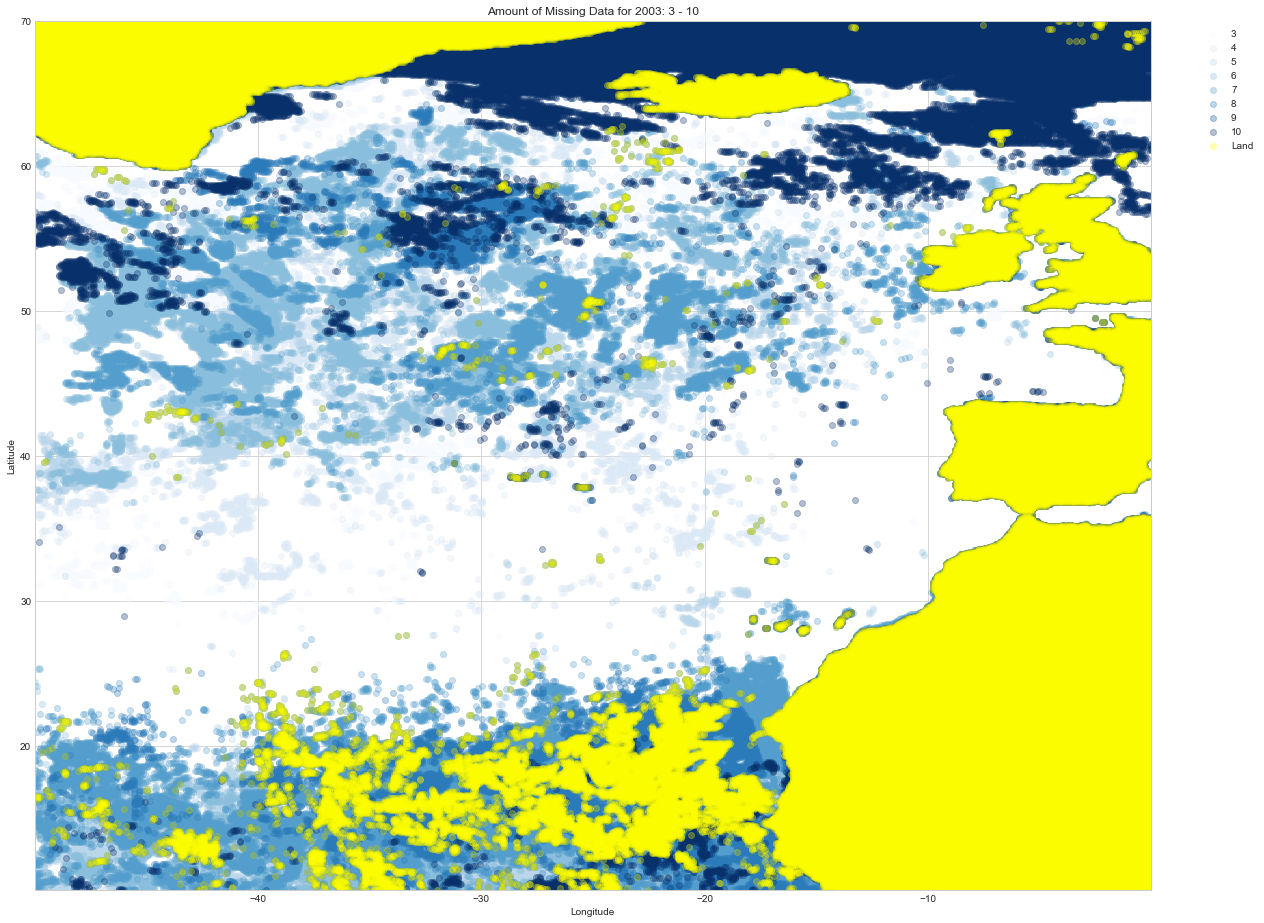

In [24]:
def evaluate_geographic_bias(year=2003, start_month=1, end_month=12):
    df = data_dict_raw[year]
    cmap=plt.get_cmap("Blues")
    colors = cmap(np.linspace(0, 1, num = end_month-start_month+1))
    fig, ax = plt.subplots(1,1,figsize=(20,16))

    num = 0
    df_temp = df[df.isnull().any(axis=1)]
    # for month, df in df_temp.groupby("month"): # more efficient, if plotting for all 12 months
    for x in range (start_month, end_month+1):
        df = df_temp[df_temp.month == x]
        ax.scatter(x=df.longitude, y=df.latitude, alpha=0.3, color=colors[num], label=x)
        num +=1 
    
    # Plot September as it has the least amount of missing values. Most likely to show the most accurate landmass.
    ax.scatter(x=df_temp[df_temp.month == 9].longitude, y=df_temp[df_temp.month == 9].latitude, 
               alpha=0.3, color='yellow', label="Land")

    ax.set_title("Amount of Missing Data for {}: {} - {}".format(year, start_month, end_month))
    ax.set_xlim(df_temp.longitude.min(), df_temp.longitude.max())
    ax.set_ylim(df_temp.latitude.min(), df_temp.latitude.max())
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(bbox_to_anchor=(1.1, 1));
    fig.savefig(("/").join([results_folder_path, str(year)+ "_" + str(start_month)+"_"+str(end_month)+".png"]))
    
evaluate_geographic_bias(year=2003, start_month=1, end_month=10)

### Results for 2003 : Jan - December
<font color=red> **•  If the image below is not showing, please check the folder & directory! </font>**

<img src="results/2003_1_12.png">

<font color=red> **Comment:**</font> 
> As the images above show, there is a significant geographic variability in the amount of missing data. The area around Antarctica (40-70°N) tends to have a lot more missing data compared to the central North Atlantic Ocean, implying that no record was collected. Another important observation is that there are less missing data near by the mainland along its border and ~30°N. 

### <font color=#0085ad> Q3 : Compare and contrast the seasonal cycle, and interannual variability in chlorophyll-⍺ in the two regions. </font>

In [26]:
# Region 1 (r_1): [45 – 50° N, -25 – -20° E]
# Region 2 (r_2): [20 – 25° N, -30 – -25° E]

# Run this when runtime = 0
r_1 = create_data_dict_raw(lat_min=45, lat_max=50, long_min=-25, long_max=-20)
r_2 = create_data_dict_raw(lat_min=20, lat_max=25, long_min=-30, long_max=-25)

# Saving to the pickle object
save_to_pickle(data_object = r_1, filename="r_1")
save_to_pickle(data_object = r_2, filename="r_2")

In [25]:
# Loading from the pickle objects after the initial setup

r_1 = read_from_pickle("r_1")
r_2 = read_from_pickle("r_2")

- Comparing the two regions for 2005 between 10 and 12


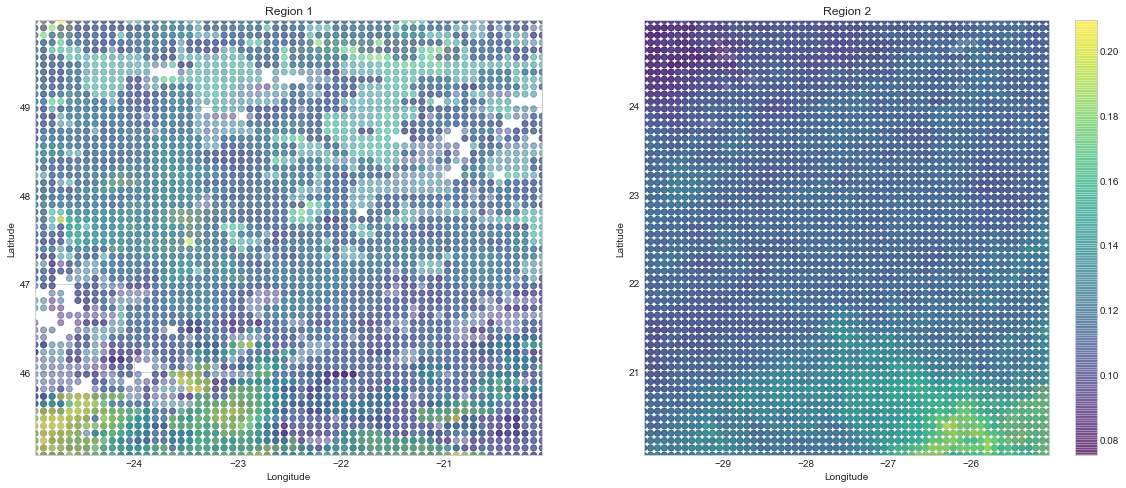

In [69]:
def compare_two_regions(year=2003, start_month=1, end_month=12):
    
    print ("- Comparing the two regions for {} between {} and {}".format(year, start_month, end_month))
    fig, axes = plt.subplots(1,2,figsize=(20,8))
    axes = axes.flatten()
    
    i = 0
    while i < 2:
        ax = axes[i]
        for x in range (start_month, end_month+1):
            df_temp = r_1[year] if i == 0 else r_2[year] 
            df = df_temp[df_temp.month == x]
            im = ax.scatter(x=df.longitude, 
                            y=df.latitude, 
                            alpha=0.5, 
                            c= df.chlor_a_val, 
                            cmap="viridis")
            
            ax.set_title("Region {}".format(i+1))
            ax.set_xlim(df_temp.longitude.min(), df_temp.longitude.max())
            ax.set_ylim(df_temp.latitude.min(), df_temp.latitude.max())
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")
        i += 1
    fig.colorbar(im, ax=ax);
    fig.savefig(("/").join([results_folder_path, 
                            "compare_regions_"+str(year)+ "_" + str(start_month)+"_"+str(end_month)+".png"]))
        
compare_two_regions(year=2005, start_month=10, end_month=12)

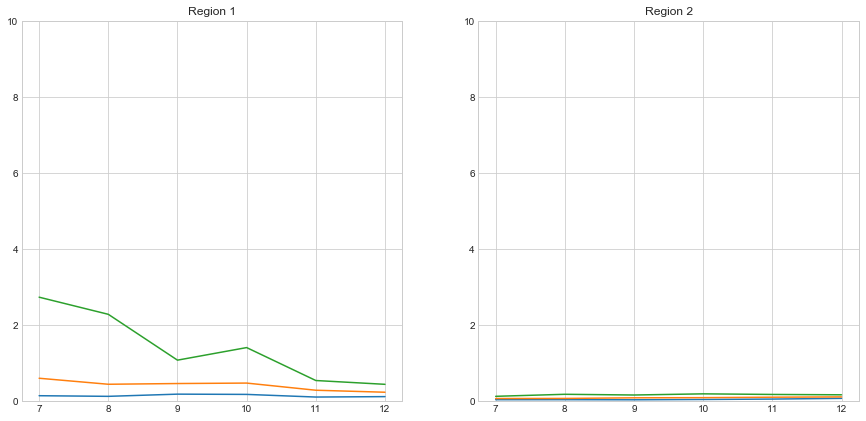

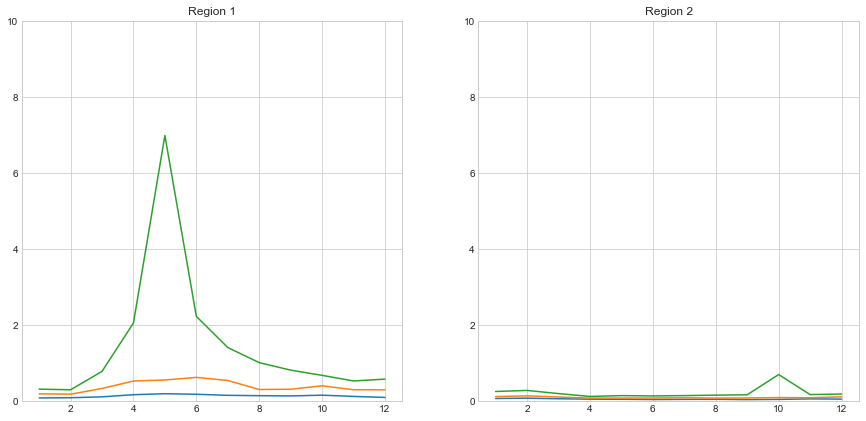

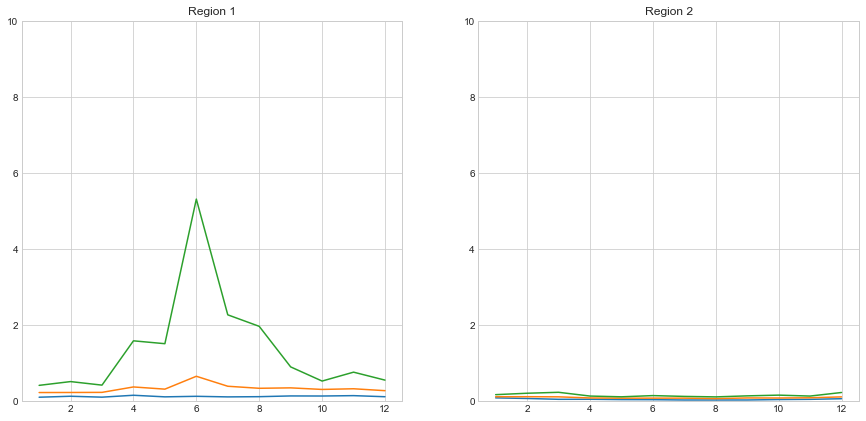

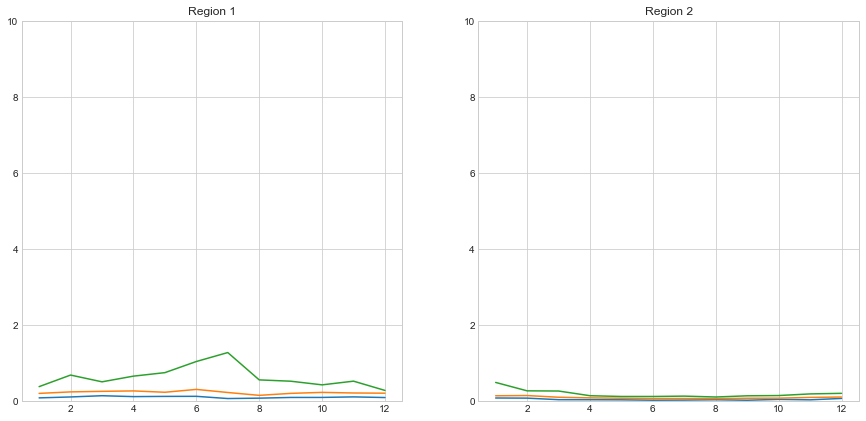

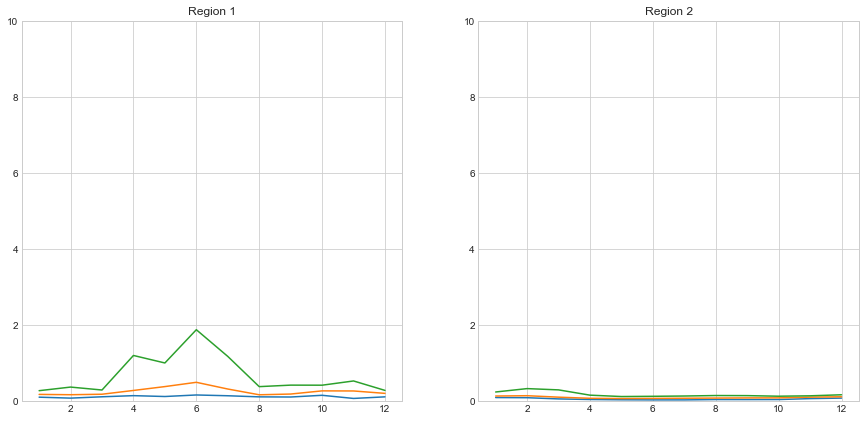

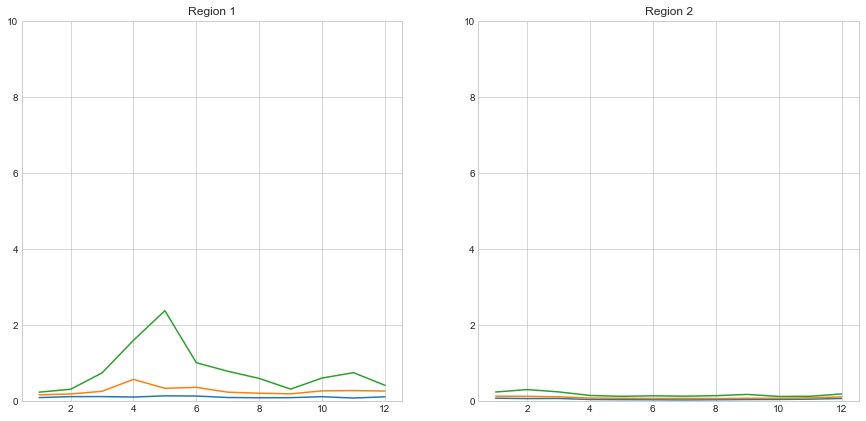

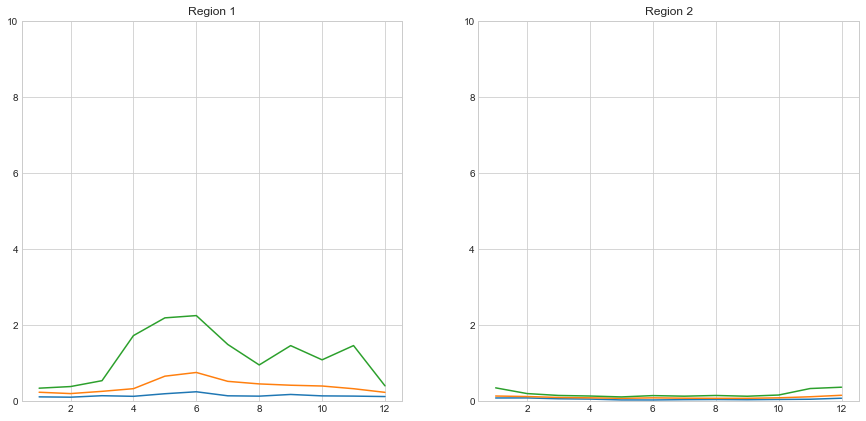

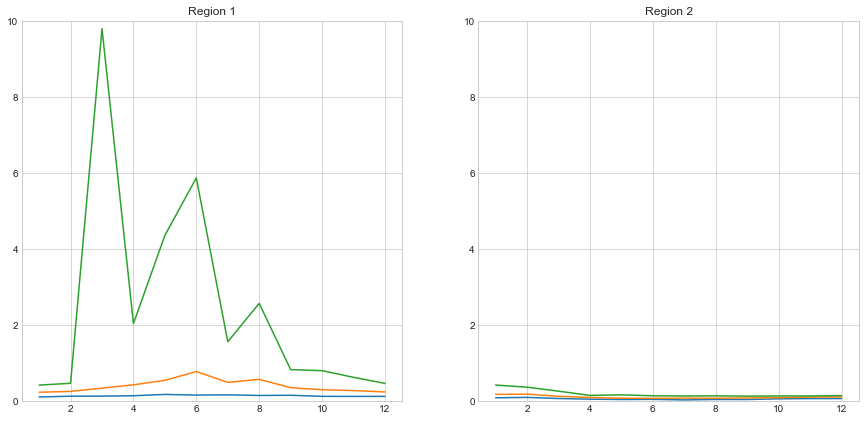

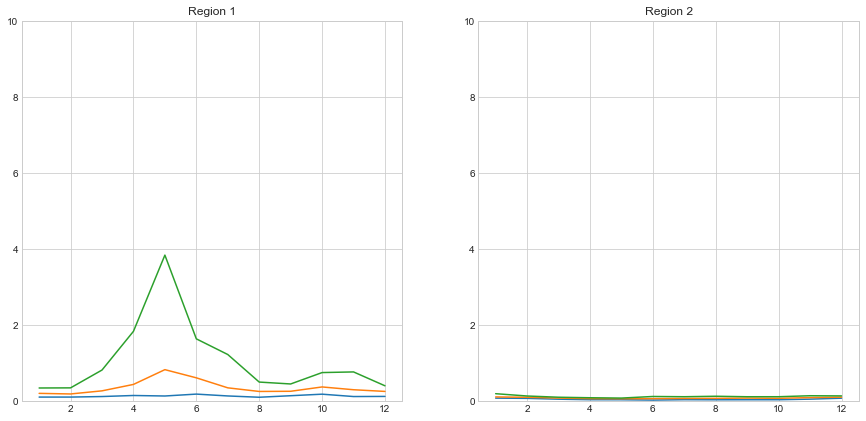

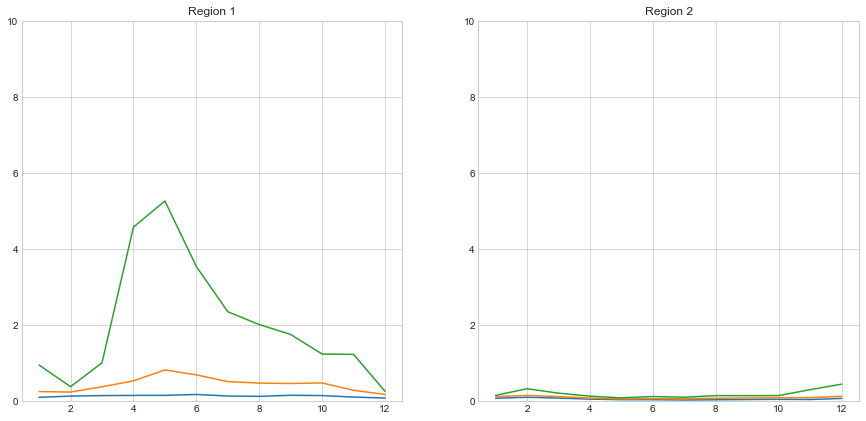

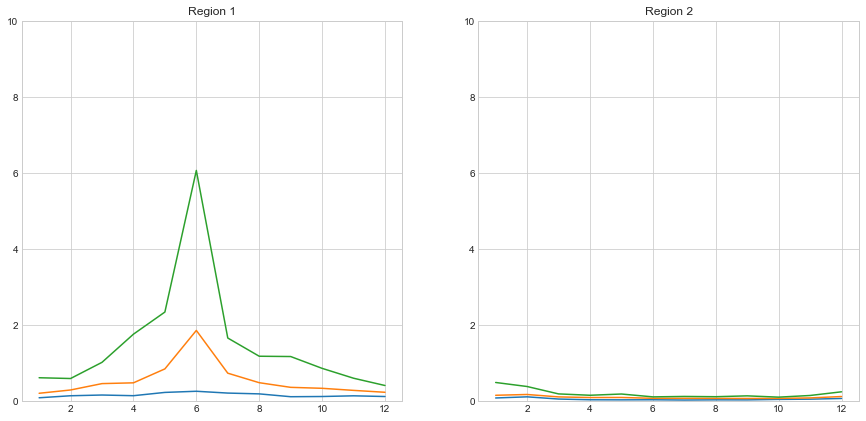

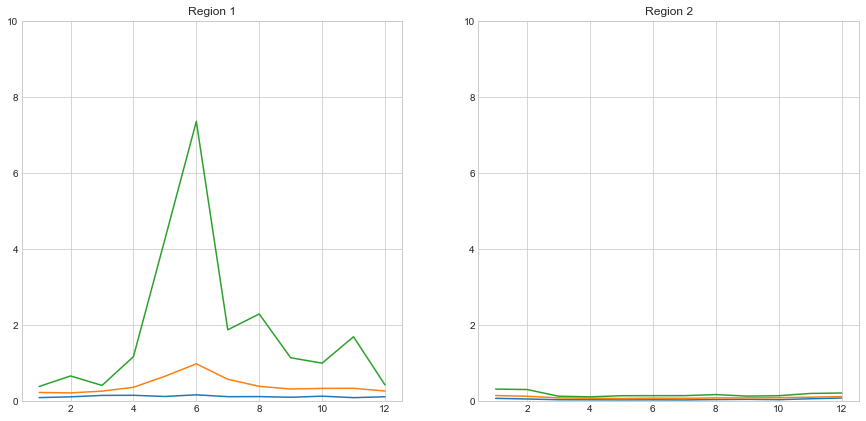

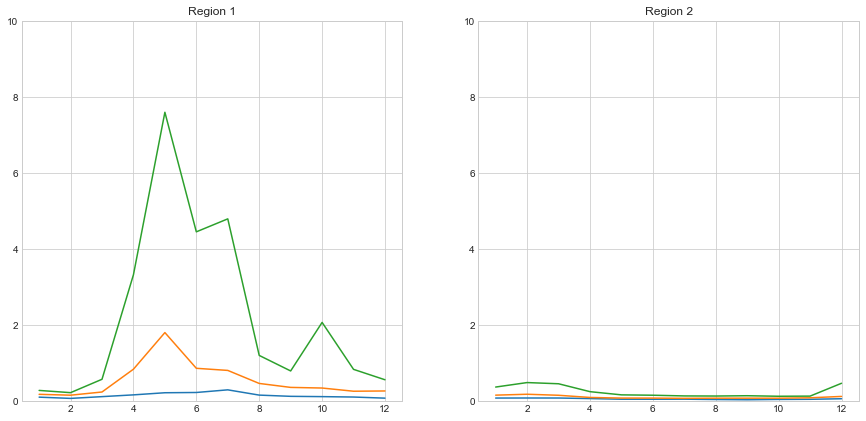

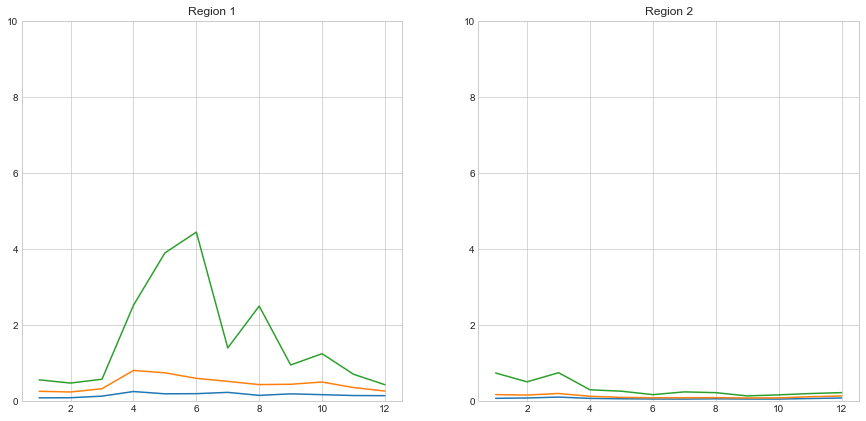

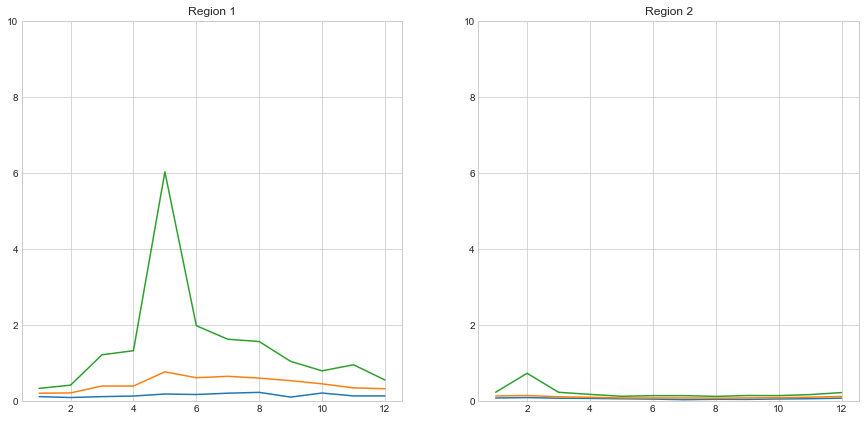

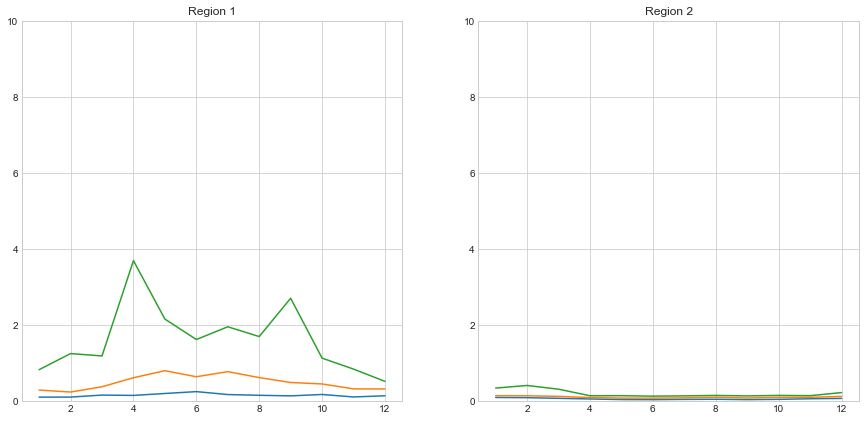

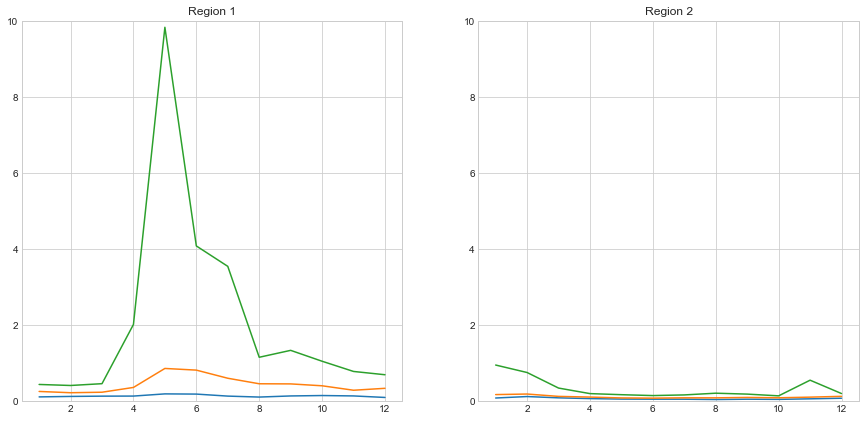

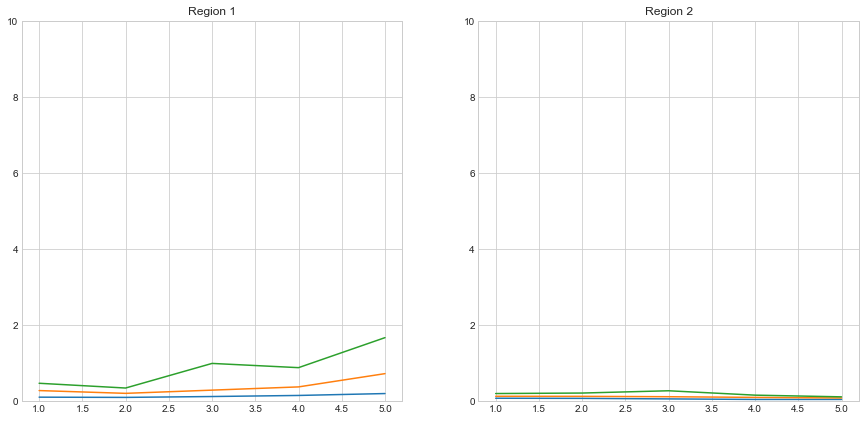

In [136]:
## This is very hacky! limit the y axis to (0,10)
def compare_two_regions_by_timeseries(year):
    plt.figure(figsize=(15,7))

    plt.subplot(121)

    df = r_1[year]
    plot_1 = df.groupby("month").agg({"chlor_a_val":{"r_1_min":"min", 
                                                       "r_1_mean":"mean",
                                                       "r_1_max":"max"}})
    plot_1.columns = plot_1.columns.droplevel(0)
    plt.plot(plot_1)
    plt.title("Region 1")
    plt.ylim(0,10)

    plt.subplot(122)

    df = r_2[year]
    plot_2 = df.groupby("month").agg({"chlor_a_val":{"r_2_min":"min", 
                                                       "r_2_mean":"mean",
                                                       "r_2_max":"max"}})
    plot_2.columns = plot_2.columns.droplevel(0)
    plt.plot(plot_2)
    plt.title("Region 2")
    plt.ylim(0,10);

for x in range(2002,2020):
    compare_two_regions_by_timeseries(year=x)

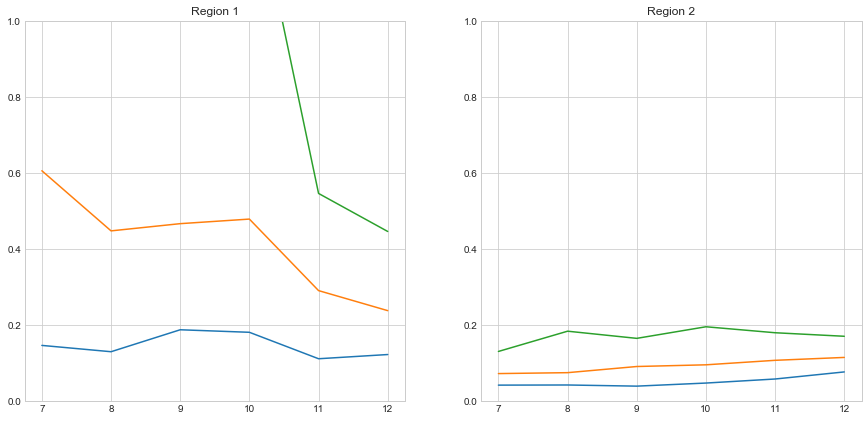

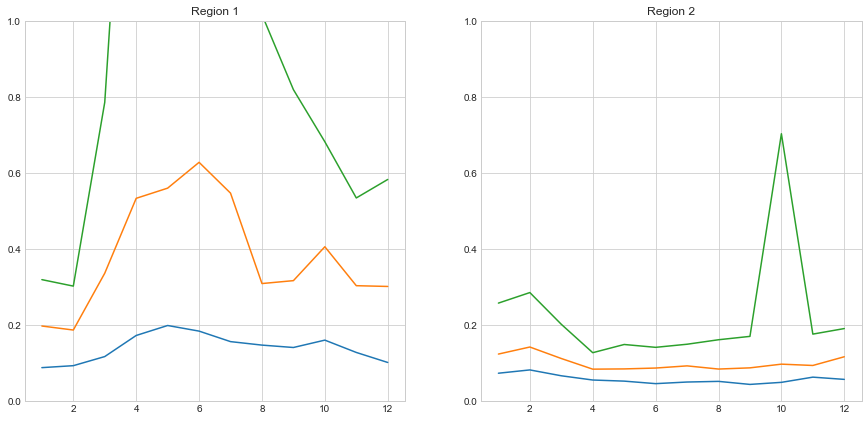

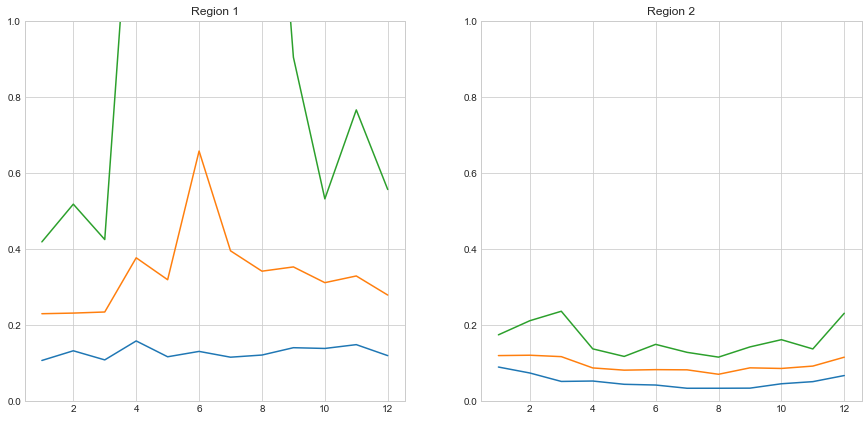

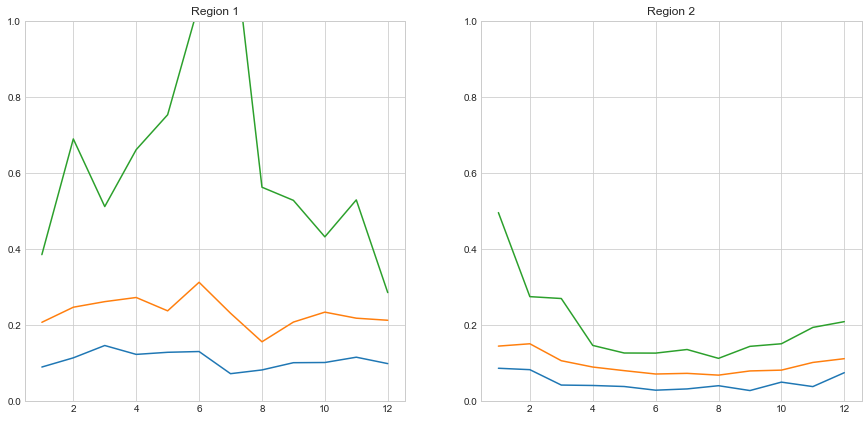

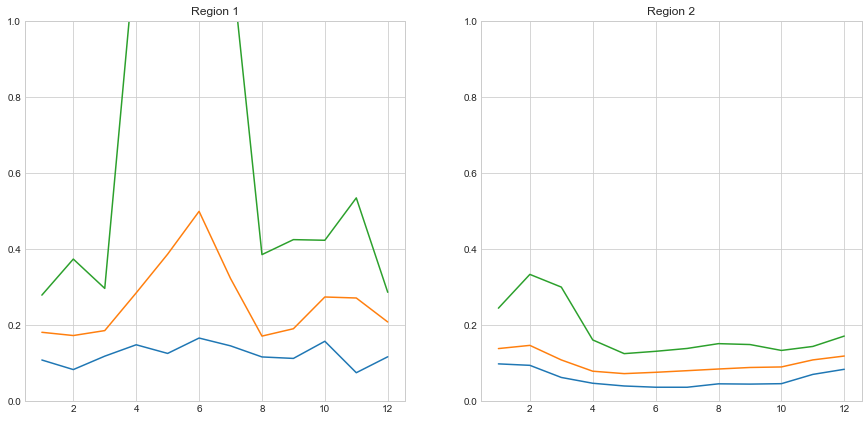

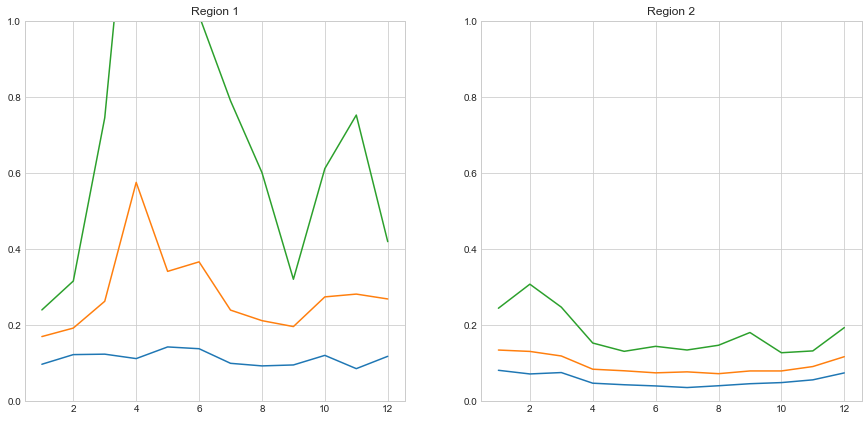

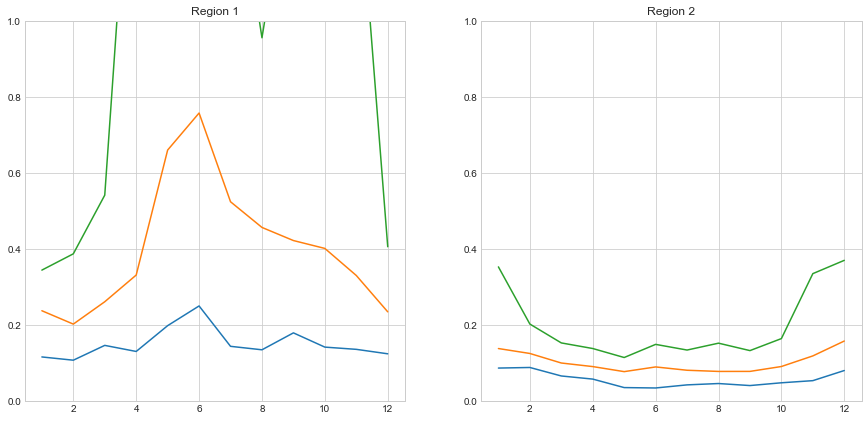

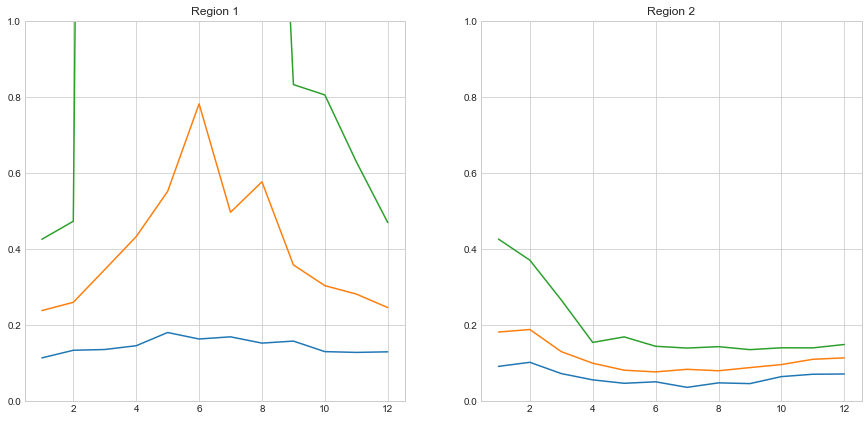

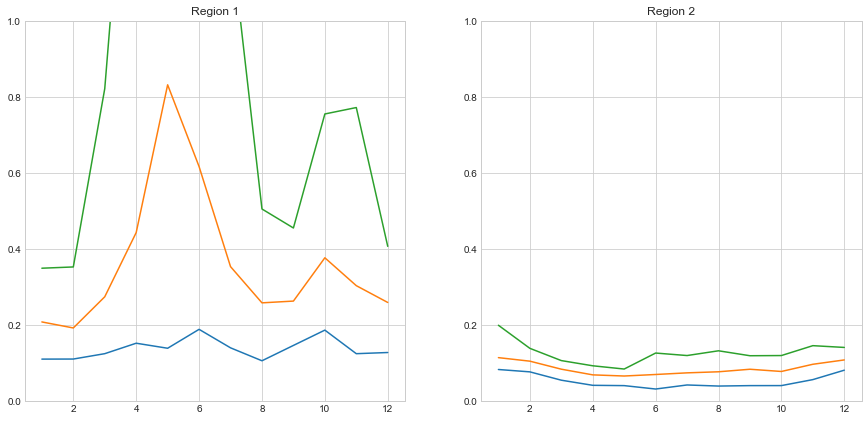

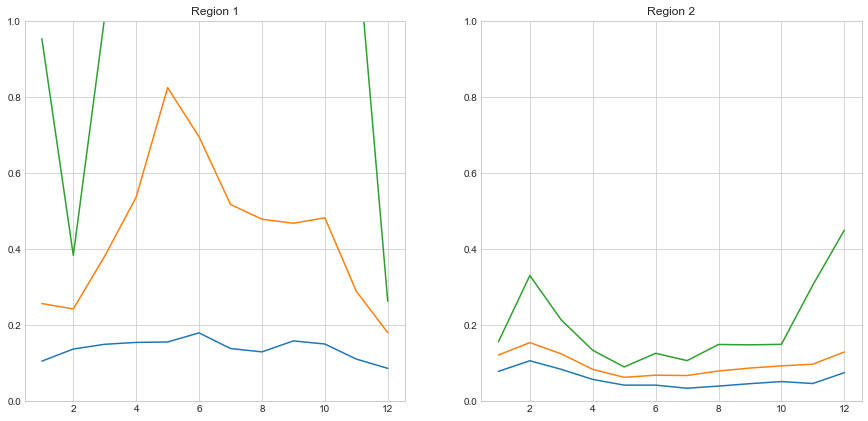

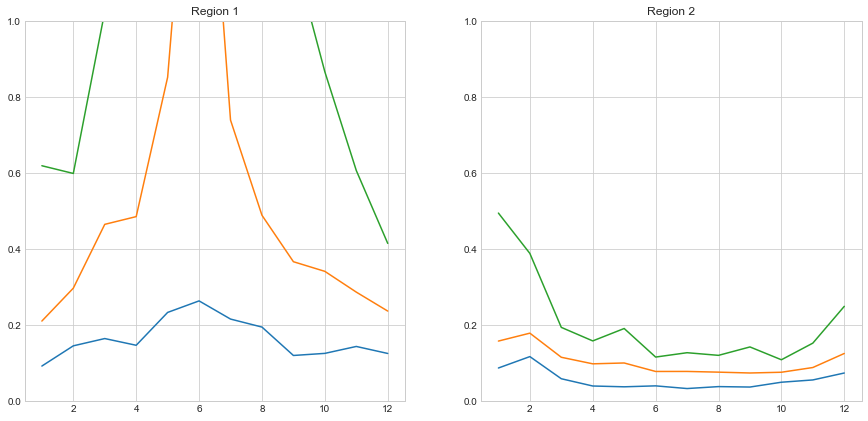

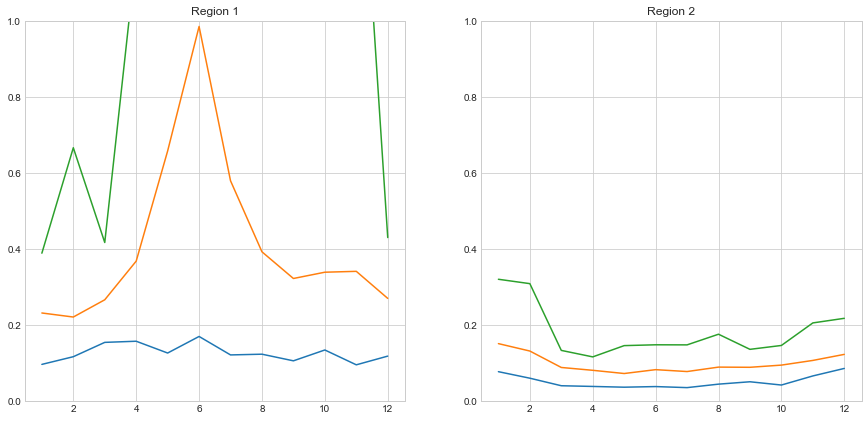

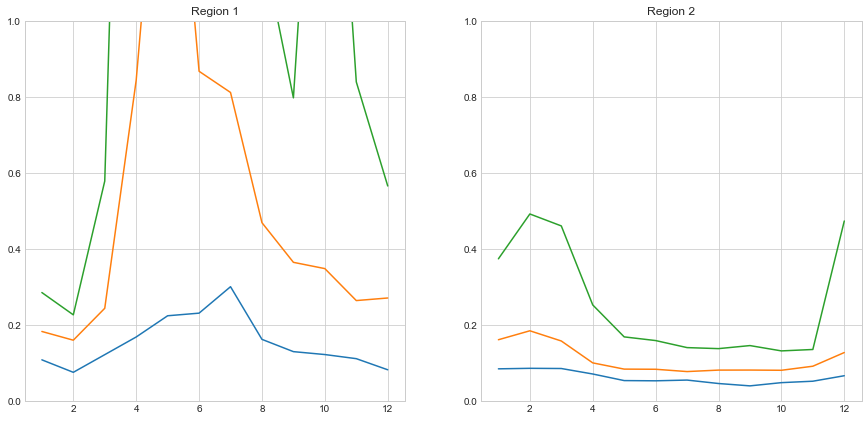

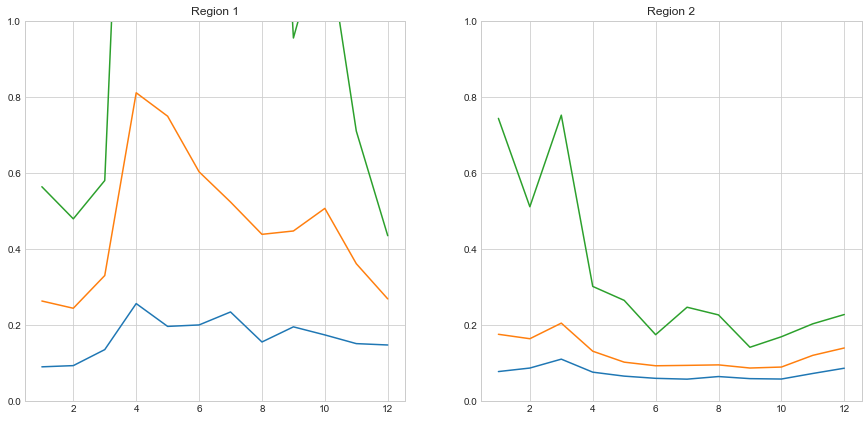

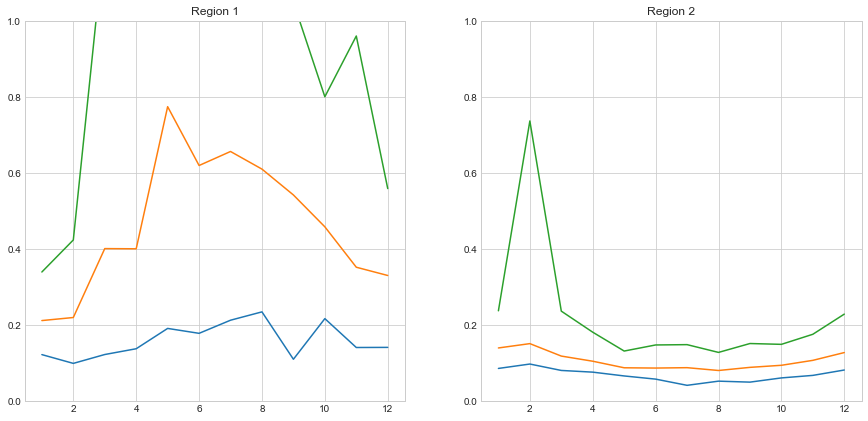

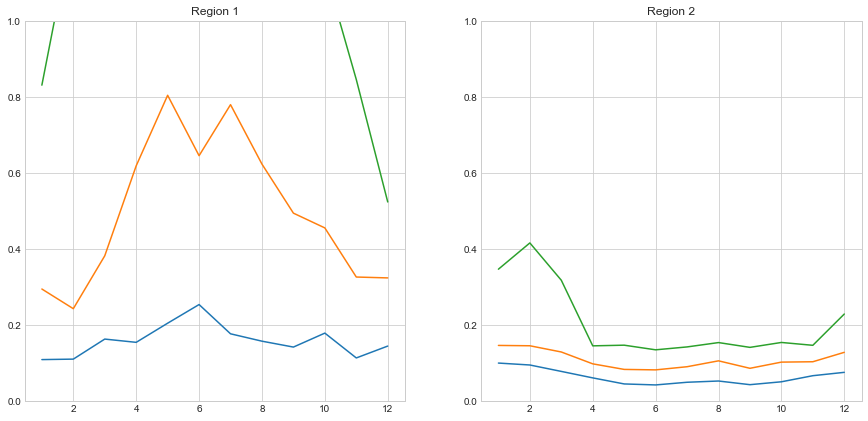

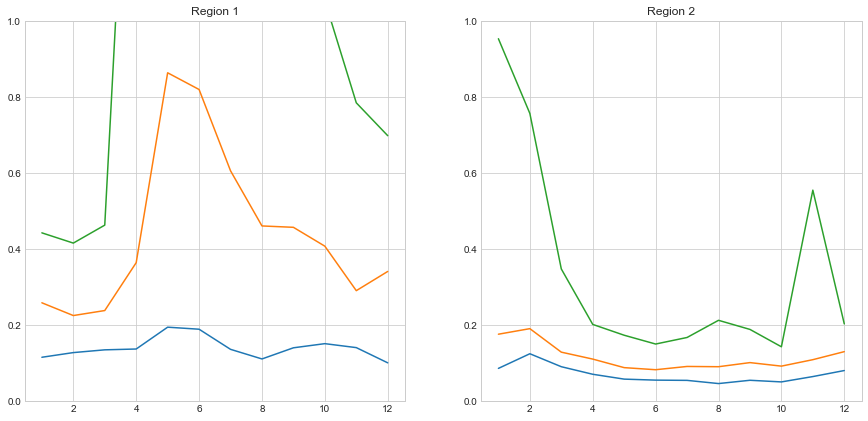

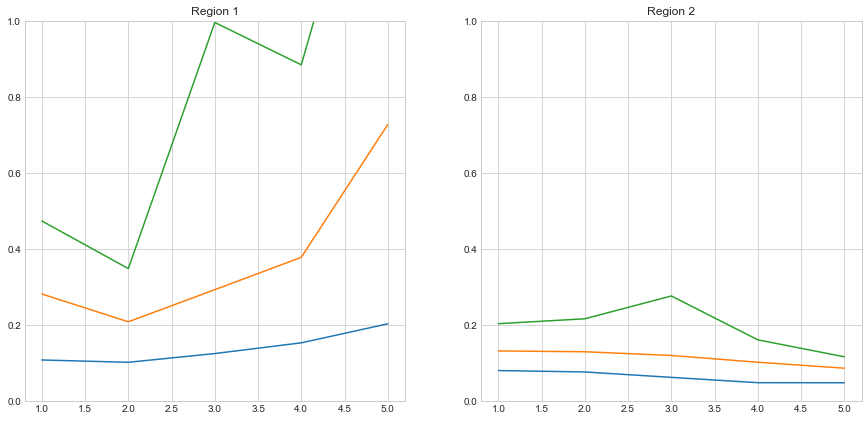

In [140]:
## This is very hacky! limit the y axis to (0,1)
def compare_two_regions_by_timeseries(year):
    plt.figure(figsize=(15,7))

    plt.subplot(121)

    df = r_1[year]
    plot_1 = df.groupby("month").agg({"chlor_a_val":{"r_1_min":"min", 
                                                       "r_1_mean":"mean",
                                                       "r_1_max":"max"}})
    plot_1.columns = plot_1.columns.droplevel(0)
    plt.plot(plot_1)
    plt.title("Region 1")
    plt.ylim(0,1)

    plt.subplot(122)

    df = r_2[year]
    plot_2 = df.groupby("month").agg({"chlor_a_val":{"r_2_min":"min", 
                                                       "r_2_mean":"mean",
                                                       "r_2_max":"max"}})
    plot_2.columns = plot_2.columns.droplevel(0)
    plt.plot(plot_2)
    plt.title("Region 2")
    plt.ylim(0,1);

for x in range(2002,2020):
    compare_two_regions_by_timeseries(year=x)

<font color=red> **Comment:**</font> 
> In the graph, the green, orange, blue lines suggest max, mean, min value of the chlorophyll-a concentration for the year of interest. According to the graphs above, it is evident that the region 1 has a far greater interannual variability. Region 1 has variability as large as 10, where as region 2 remains fairly steady below 1. In addition, although no conspicuous seasonality was observed in the region 2, region 1 tended to have a weak seasonality where it shows an abrupt increase in concentration around in June every year.

###  <font color=#0085ad> Q4 : Identify the areas in the North Atlantic that tend to experience similar variations in chlorophyll-a. Describe the different modes of variability. (Hint: there are multiple ways to do this, from principal component analysis to simple regression. “Variations” are not limited to seasonal cycles.) </font>

In [48]:
def modify_column(x):
    new_col_name = ("_").join([str(x.year.loc[0]), str(x.month.loc[0])])
    x[new_col_name] = x.chlor_a_val
    return x[["longitude", "latitude", new_col_name]]

In [49]:
def merge_data(temp_df):
    assert len(temp_df) > 0, "There is no data to merge on"
    
    temp_final = temp_df[0]
    for i in range(len(temp_df)-1):
        temp_final = pd.merge(temp_final, temp_df[i+1], 
                              on=["longitude", "latitude"], 
                              how="inner")
        assert temp_final.shape[0] == 864000, "There could be some information due to missing values"
    return temp_final

In [50]:
def get_df_mg_dict(data_collection):
    df_mg_d = {}
    for year, data in data_collection.items():
        print ("Processing year: {}".format(year))
        temp_df = list(map(modify_column, data))
        df_mg_d[year] = merge_data(temp_df)
    return df_mg_d

In [64]:
data_collection_merged = get_df_mg_dict(data_collection=data_collection_raw)
save_to_pickle(data_object=data_collection_merged, file_name="data_collection_merged")

Processing year: 2002
Processing year: 2003
Processing year: 2004
Processing year: 2005
Processing year: 2006
Processing year: 2007
Processing year: 2008
Processing year: 2009
Processing year: 2010
Processing year: 2011
Processing year: 2012
Processing year: 2013
Processing year: 2014
Processing year: 2015
Processing year: 2016
Processing year: 2017
Processing year: 2018
Processing year: 2019


<font color=red> **Comment:**</font> 
>Another dataframe for historical data was prepared. It's variable name is "df_complete" to perform K-means clustering.

In [75]:
# Preparing and saving the data into csv 
df_complete = merge_data(list(data_collection_merged.values()))
df_complete.to_csv(("/").join([pickle_folder_path, "historical_data.csv"]), index=False)
df_complete.head()

longitude   latitude  2002_7    2002_8    2002_9  2002_10  \
0  -99.98147719379486  69.990736     NaN  0.393458  0.399871      NaN   
1  -99.98147719379486  69.907365     NaN  0.446665  0.412648      NaN   
2  -99.98147719379486  69.823993     NaN  0.462188  0.420744      NaN   
3  -99.98147719379486  69.740621     NaN  0.470372  0.465426      NaN   
4  -99.98147719379486  69.657249     NaN  0.539727  0.512398      NaN   

   2002_11  2002_12  2003_1  2003_2   ...      2018_8  2018_9  2018_10  \
0      NaN      NaN     NaN     NaN   ...    0.333480     NaN      NaN   
1      NaN      NaN     NaN     NaN   ...    0.475556     NaN      NaN   
2      NaN      NaN     NaN     NaN   ...         NaN     NaN      NaN   
3      NaN      NaN     NaN     NaN   ...    0.553834     NaN      NaN   
4      NaN      NaN     NaN     NaN   ...    0.502515     NaN      NaN   

   2018_11  2018_12  2019_1  2019_2  2019_3  2019_4  2019_5  
0      NaN      NaN     NaN     NaN     NaN     NaN     NaN  
1      NaN      NaN     NaN     NaN     NaN     NaN     NaN  
2      NaN      NaN     NaN     NaN     NaN     NaN     NaN  
3      NaN      NaN     NaN     NaN     NaN     NaN     NaN  
4      NaN      NaN     NaN     NaN     NaN     NaN     NaN  

[5 rows x 205 columns]

In [51]:
# Reading the data 
df_complete = pd.read_csv(("/").join([pickle_folder_path, "historical_data.csv"]))

In [52]:
test = df_complete.copy()
test["num_missing"] = test.isnull().sum(axis=1)
test["num_missing_percentage"] = test.num_missing/df_complete.shape[1]*100
test["covered_percentage"] = 100.0 - test.num_missing_percentage
test.head(2)

longitude   latitude  2002_7    2002_8    2002_9  2002_10  2002_11  \
0 -99.981477  69.990736     NaN  0.393458  0.399871      NaN      NaN   
1 -99.981477  69.907365     NaN  0.446665  0.412648      NaN      NaN   

   2002_12  2003_1  2003_2         ...          2018_11  2018_12  2019_1  \
0      NaN     NaN     NaN         ...              NaN      NaN     NaN   
1      NaN     NaN     NaN         ...              NaN      NaN     NaN   

   2019_2  2019_3  2019_4  2019_5  num_missing  num_missing_percentage  \
0     NaN     NaN     NaN     NaN          180               87.804878   
1     NaN     NaN     NaN     NaN          182               88.780488   

   covered_percentage  
0           12.195122  
1           11.219512  

[2 rows x 208 columns]

In [9]:
# Data summary 1
test.covered_percentage.describe()

count    864000.000000
mean         57.716021
std          41.217001
min           0.975610
25%           0.975610
50%          70.731707
75%          97.560976
max         100.000000
Name: covered_percentage, dtype: float64

In [53]:
# Data summary 2
test[test["covered_percentage"]>10].covered_percentage.describe()

count    602112.000000
mean         82.367047
std          20.804090
min          10.243902
25%          67.804878
50%          92.682927
75%          99.024390
max         100.000000
Name: covered_percentage, dtype: float64

<font color=red> **Comment:**</font> 
> Although the value of 80 and the value of K for K-means clustering algroithm are arbitraily chosen due to the time constraint,  in the real analysis it should be carefully chosen through cross-validation and "elbow" method.

In [13]:
# Drop data whose data availability is below 80 percent to speed up computing process

test_bfill = test[test.covered_percentage > 80].fillna(method="bfill")
test_bfill.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386106 entries, 637 to 863689
Columns: 208 entries, longitude to covered_percentage
dtypes: float64(207), int64(1)
memory usage: 615.7 MB


#### <font color=#0085ad> K-means Clustering Result

In [14]:
y = np.array(test_bfill[["longitude", "latitude"]])
X = np.array(test_bfill.iloc[:,2:-3])
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(X)
test_bfill["cluster"] = kmeans.labels_
test_bfill.head()

longitude   latitude    2002_7    2002_8    2002_9   2002_10   2002_11  \
637 -99.981477  16.882816  0.665200  0.244398  0.690119  1.289184  1.456111   
638 -99.981477  16.799444  0.569593  0.218627  0.666033  0.677733  1.188108   
639 -99.981477  16.716072  0.252576  0.184364  0.263340  0.556808  0.768077   
640 -99.981477  16.632700  0.172077  0.215953  0.359292  0.407345  0.752215   
641 -99.981477  16.549328  0.149023  0.212198  0.515857  0.393934  0.532437   

      2002_12    2003_1    2003_2   ...      2018_12    2019_1    2019_2  \
637  0.519487  0.499293  5.302340   ...     0.360809  0.228596  2.280577   
638  0.417576  0.307357  1.803678   ...     0.287286  0.212363  0.697835   
639  0.273187  0.213714  0.872255   ...     0.194787  0.201079  0.525753   
640  0.245895  0.176811  0.942287   ...     0.197646  0.207225  0.362334   
641  0.234478  0.162151  0.692823   ...     0.173443  0.189654  0.268254   

       2019_3    2019_4    2019_5  num_missing  num_missing_percentage  \
637  4.800007  2.426786  0.303196           11                5.365854   
638  2.005744  1.683046  0.303196            5                2.439024   
639  0.625775  0.472858  0.303196            3                1.463415   
640  0.484132  0.380365  0.272630            3                1.463415   
641  0.395123  0.396125  0.259653            2                0.975610   

     covered_percentage  cluster  
637           94.634146        4  
638           97.560976        0  
639           98.536585        0  
640           98.536585        0  
641           99.024390        0  

[5 rows x 209 columns]

In [15]:
# Save the data into csv 
test_bfill.to_csv(("/").join([pickle_folder_path, "cluster_result.csv"]), index=False)

In [8]:
# Reading the data 
test_bfill = pd.read_csv(("/").join([pickle_folder_path, "cluster_result.csv"]))

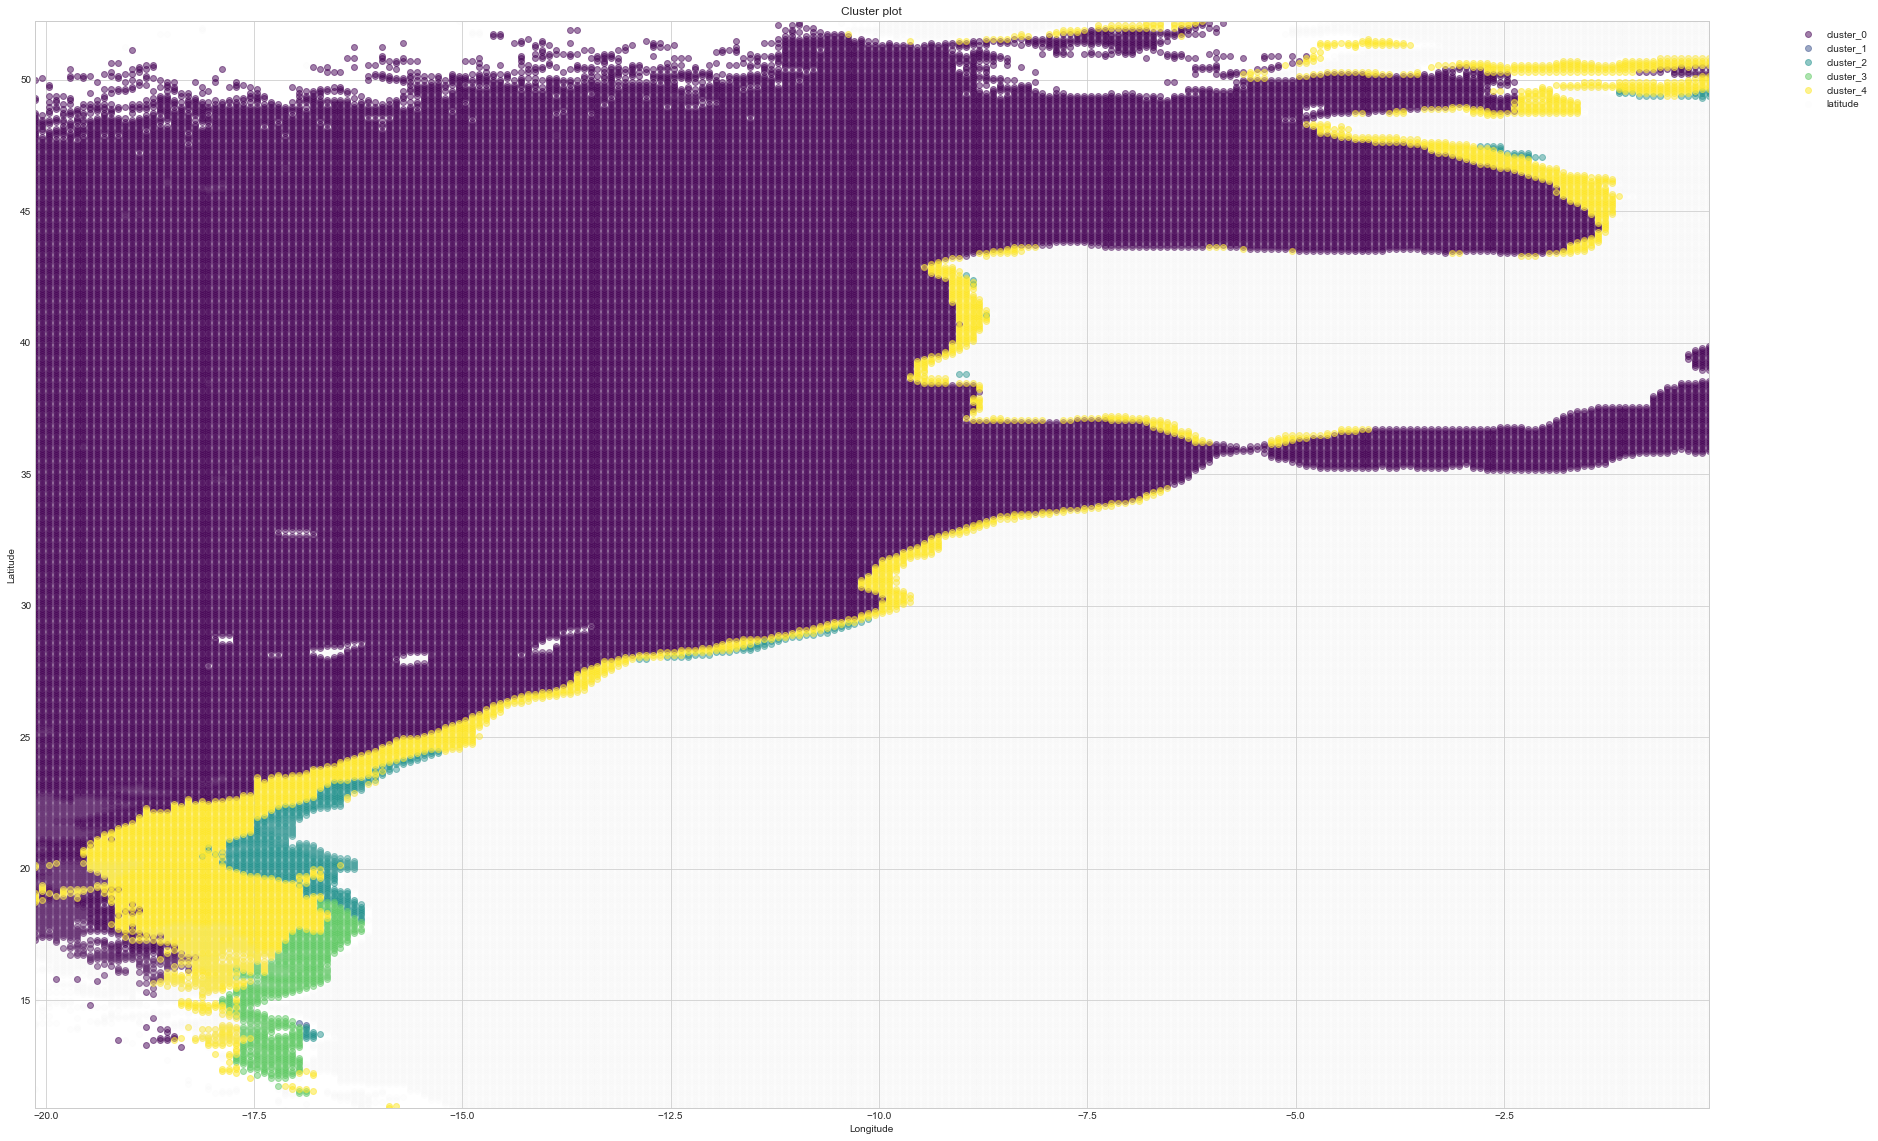

In [11]:
def plot_clusters(df=test_bfill, limit_lat_long=False, with_land=False):
    cmap=plt.get_cmap("viridis")
    colors = cmap(np.linspace(0, 1, num=5))

    fig, ax = plt.subplots(1,1,figsize=(30,20)) #adjust if plotting the full image!
    df.longitude = df.longitude.astype(float)
    
    if limit_lat_long:
        df = df[(df.longitude < 0) & (df.longitude >= -50)]
    
    num = 0
    for cluster, df in df.groupby("cluster"):
        ax.scatter(x=df.longitude, 
                       y=df.latitude, 
                       alpha=0.5, 
                       color=colors[num], 
                       label="cluster_"+str(cluster))
        num +=1 

    if with_land:
        test = data_dict_raw[2003] #2003 arbitraily chosen
        test_temp = test[test.isnull().any(axis=1)]
        ax.scatter(x=test_temp[test_temp.month == 9].longitude, y=test_temp[test_temp.month == 9].latitude, 
                   alpha=0.05, color='#E8E8E8')

    ax.set_title("Cluster plot")
    ax.set_xlim(df.longitude.min(), df.longitude.max())
    ax.set_ylim(df.latitude.min(), df.latitude.max())
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.legend(bbox_to_anchor=(1.1, 1));
    
    fig.savefig(("/").join([results_folder_path, "k_5_clustering_results_lat_long_limited.png"]))
plot_clusters(limit_lat_long=True, with_land=True)

## <font color=#003666> Part II: Quantitative decision making </font>
###  <font color=#0085ad> Q1: A fishing fleet is interested in deploying to the region of the North Atlantic Ocean that is both high in chlorophyll-a, and experiences high chlorophyll-a relatively early in the year, compared to other high-chlorophyll regions. Where should they go? Note that it is up to you to define “high” and “early” in this context. </font>

<font color=red> **Comments:**</font>
> **Quick Answer**: Based on the graph below, it is beneficial to deploy the region in **cluster_1**, which on average has higher chlorophyll concentration in earlier season than other clusters.

>**Alternative Option**: Assuming that the concentration of chlorophyll-a is a good feature that would be a good indicator of the amount of planktons, find the density plot for each (lat,long) tuple.  If the feautre has a normal distribution, compute the individual mean and standard deviation. Determine a threshold value, (ε), above which will be classified as anomaly. Depending on the number of deviation away from the mean, we could distinguish which (lat,long) coordinates tends to have abnomrally higher concentration of chlorophyll-a in earlier season than others. 

> Although we only have concentration of chlorophyl-a data, it would be extremely helpful to have other features that could help explain and substantiate the anomalies, such as  sea surface temperature, wind speed/direction, and so on.

In [141]:
# df for part 2 
df_2 = test_bfill.reset_index(drop=True)
columns_to_keep = list(df_2.columns[2:-4])+[df_2.columns[-1]]
df_2 = df_2[columns_to_keep]
df_2.groupby("cluster").agg("mean")

# Save the file to plot in Excel - memory issue. Can be resolved by using an AWS EC2 host.
# df_2.groupby("cluster").agg("mean").reset_index().to_csv(("/").join([pickle_folder_path, "cluster_agg.csv"]), index=False)


2002_7     2002_8     2002_9    2002_10    2002_11    2002_12  \
cluster                                                                     
0         0.173986   0.153300   0.165817   0.183429   0.208765   0.204903   
1        23.894133  17.158011  17.800183  17.029317  18.749005  18.959620   
2         9.159606   8.774588   8.597710   9.239016   6.389666   5.860995   
3         1.371846   0.514322   0.719882   4.876495   5.258337   3.951222   
4         2.359749   2.376776   2.782106   2.261085   2.100118   2.202414   

            2003_1     2003_2     2003_3     2003_4    ...         2018_8  \
cluster                                                ...                  
0         0.216791   0.223183   0.261536   0.319291    ...       0.150450   
1        19.298832  20.384227  19.820512  21.029603    ...      22.914935   
2         5.492390   5.098230   6.302532   7.074757    ...       9.951810   
3         7.125515  11.240294  13.156878  11.327900    ...       0.761785   
4         1.982737   2.284147   3.272000   2.987919    ...       2.182866   

            2018_9    2018_10    2018_11    2018_12     2019_1     2019_2  \
cluster                                                                     
0         0.149549   0.179477   0.212088   0.226987   0.237062   0.246381   
1        19.409813  14.882498  14.527849  14.366510  12.508919  13.612992   
2         8.075086   8.454721   6.691461   7.054501   6.319181   6.770180   
3         0.716538   1.738645   5.216665   5.724827   9.298484  11.373309   
4         2.087700   2.387264   2.324044   2.737895   2.494086   2.876754   

            2019_3     2019_4     2019_5  
cluster                                   
0         0.269166   0.314655   0.306833  
1        14.147038  18.177012  19.379448  
2         7.339113   7.791571   8.961155  
3         9.680485  15.018055  15.217389  
4         2.742318   2.683248   2.739737  

[5 rows x 203 columns]

<font color=red> **•  If the image below is not showing, please check the folder & directory! </font>**

<img src="results/cluster_time_series.png">